In [1]:
import os

In [2]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-10-26 11:32:11.536750: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 11:32:11.541108: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 11:32:11.583249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 11:32:11.583288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 11:32:11.584754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
import random
from pathlib import Path
import time
import argparse
import json
import submitit
import shutil

In [4]:
from OptimizedDataGenerator import OptimizedDataGenerator
from loss import custom_loss
from models import CreateModel

/home/hep/hl2822/smart-pixels-ml/smart-pixel/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [5]:
epochs = 200
batch_size = 256
val_batch_size = 256
train_file_size = 20
val_file_size = 5
n_filters = 5
pool_size = 3
learning_rate = 0.001
early_stopping_patience = 50

In [6]:
# paths
data_directory_path = "./datasets/recon3D/" # "/net/scratch/badea/dataset8/unflipped/"
labels_directory_path = "./datasets/labels/" # "/net/scratch/badea/dataset8/unflipped/"

# create tf records directory
# stamp = '%08x' % random.randrange(16**8)
stamp = "3e778b82"
output_directory = Path(f"./tfrecords_{stamp}").resolve()
os.makedirs(output_directory, exist_ok=True)
tfrecords_dir_train = Path(output_directory, f"tfrecords_train_{stamp}").resolve()
tfrecords_dir_validation = Path(output_directory, f"tfrecords_validation_{stamp}").resolve()
tfrecords_dir_test = Path(output_directory, f"tfrecords_test_{stamp}").resolve()

In [8]:
stamp = "3e778b82"

In [7]:
# Trainning Generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    file_count = train_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    save=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_train,
)
print(f"Training data generator created in {time.time() - start_time} seconds.")

Directory /home/hep/hl2822/smart-pixels-ml/tfrecords_3e778b82/tfrecords_train_3e778b82 does not exist and cannot be removed.
Found 20 files to process
First file: ./datasets/recon3D/recon3D_d17301.parquet


Processing Files...: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

Saving batches as TFRecords: 100%|██████████| 3905/3905 [01:08<00:00, 56.89it/s] 



Training data generator created in 91.81210994720459 seconds.


In [ ]:
training_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/hl2822/smart-pixels-ml/tfrecords_{stamp}/tfrecords_train_{stamp}/",
shuffle = True,
seed = 13,
quantize = True # Try false
)

In [9]:
start_time = time.time()
validation_generator = OptimizedDataGenerator(
    data_directory_path = data_directory_path,
    labels_directory_path = labels_directory_path,
    is_directory_recursive = False,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,13,21), # (20,13,21),
    transpose = (0,2,3,1),
    files_from_end=True,
    use_time_stamps = [0,19],
    tfrecords_dir = tfrecords_dir_validation,
)
print(f"Validation data generator created in {time.time() - start_time} seconds.")

Directory /home/hep/hl2822/smart-pixels-ml/tfrecords_3e778b82/tfrecords_validation_3e778b82 does not exist and cannot be removed.
Found 5 files to process
First file: ./datasets/recon3D/recon3D_d17456.parquet


Saving batches as TFRecords: 100%|██████████| 976/976 [00:16<00:00, 59.95it/s] 



Validation data generator created in 22.42323398590088 seconds.


In [8]:
validation_generator = OptimizedDataGenerator(
load_from_tfrecords_dir = f"/home/hep/hl2822/smart-pixels-ml/tfrecords_{stamp}/tfrecords_validation_{stamp}/",
shuffle = True,
seed = 13,
quantize = True
)

In [9]:
model = CreateModel((13,21,2), n_filters=5, pool_size=3)
model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_loss)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [10]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, Callback

checkpoint_directory = Path(f"./checkpoints_{stamp}").resolve()
checkpoint_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

checkpoint_filepath = Path(checkpoint_directory, 'weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5').resolve()

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=False,
)

csvlogger_directory = Path("./csvlogs").resolve()
csvlogger_directory.mkdir(parents=True, exist_ok=True)  # Create directory if it doesn't exist

csv_logger = CSVLogger(Path(csvlogger_directory, f'training_log_{stamp}.csv').resolve(), append=True)

print(f"✓ Checkpoint directory: {checkpoint_directory}")
print(f"✓ Checkpoint files will be saved as: weights.XX-tX.XX-vX.XX.hdf5")

✓ Checkpoint directory: /home/hep/hl2822/smart-pixels-ml/checkpoints_3e778b82
✓ Checkpoint files will be saved as: weights.XX-tX.XX-vX.XX.hdf5


In [ ]:
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    callbacks=[es, mcp, csv_logger],
                    epochs=epochs,
                    shuffle=False, # shuffling now occurs within the data-loader
                    verbose=1)

Epoch 1/200


Epoch 1/200


ValueError: in user code:

    File "/home/hep/hl2822/smart-pixels-ml/smart-pixel/lib64/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/hep/hl2822/smart-pixels-ml/loss.py", line 20, in custom_loss  *
        row2 = tf.stack([Mcov[:,0],Mdia[:,1],zeros,zeros])

    ValueError: slice index 0 of dimension 1 out of bounds. for '{{node custom_loss/strided_slice_5}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2](custom_loss/strided_slice_2, custom_loss/strided_slice_5/stack, custom_loss/strided_slice_5/stack_1, custom_loss/strided_slice_5/stack_2)' with input shapes: [?,0], [2], [2], [2] and with computed input tensors: input[1] = <0 0>, input[2] = <0 1>, input[3] = <1 1>.


In [14]:
# Find the latest checkpoint file
import glob

checkpoint_directory = Path(f"./checkpoints_{stamp}").resolve()
checkpoint_files = sorted(glob.glob(str(checkpoint_directory / "weights.*.hdf5")))
checkpoint_files_directory = "/home/hep/hl2822/smart-pixels-ml/checkpoints_3e778b82/weights.117-t-1220.46-v-1137.35.hdf5"

checkpoint_files = sorted(glob.glob(str(checkpoint_files_directory)))

if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]
    print(f"Loading weights from: {latest_checkpoint}")
    model.load_weights(latest_checkpoint)
    
    # Extract epoch number from filename to resume training
    import re
    match = re.search(r'weights\.(\d+)-', latest_checkpoint)
    if match:
        initial_epoch = int(match.group(1)) + 1
        print(f"Resuming from epoch {initial_epoch}")
    else:
        initial_epoch = 0
else:
    print("No checkpoint files found, starting from scratch")
    initial_epoch = 0

# Now train with initial_epoch parameter
history = model.fit(x=training_generator,
                    validation_data=validation_generator,
                    callbacks=[es, mcp, csv_logger],
                    epochs=epochs,
                    initial_epoch=initial_epoch,  # Add this parameter
                    shuffle=False,
                    verbose=1)

Loading weights from: /home/hep/hl2822/smart-pixels-ml/checkpoints_3e778b82/weights.117-t-1220.46-v-1137.35.hdf5
Resuming from epoch 118
Epoch 119/200
2854/3905 [====================>.........] - ETA: 55s - loss: -1213.8179

KeyboardInterrupt: 

In [11]:
import tensorflow as tf
import random
from pathlib import Path
import pandas as pd
import argparse
import submitit
import json 
import numpy as np
import shutil

minval=1e-9

def evaluate(config):

    # update %j with actual job number
    try:
        job_env = submitit.JobEnvironment()
        config["outFileName"] = Path(str(config["outFileName"]).replace("%j", str(job_env.job_id)))
    except:
        config["outFileName"] = Path(str(config["outFileName"]).replace("%j", "%08x" % random.randrange(16**8)))
    output_directory = config["outFileName"].parent
    os.makedirs(output_directory, exist_ok=True)
    print(output_directory)

    # create tf records directory
    tfrecords_dir = Path(output_directory, f"tfrecords_{'%08x' % random.randrange(16**8)}").resolve()
    
    # data generator
    # test_generator = OptimizedDataGenerator(
    #     data_directory_path = config["data_directory_path"],
    #     labels_directory_path = config["labels_directory_path"],
    #     is_directory_recursive = False,
    #     file_type = "parquet",
    #     data_format = "3D",
    #     batch_size = config["val_batch_size"],
    #     file_count = config["val_file_size"],
    #     to_standardize= True,
    #     include_y_local= False,
    #     labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    #     input_shape = (2,13,21), # (20,13,21),
    #     transpose = (0,2,3,1),
    #     files_from_end=True,
    #     use_time_stamps = [0,19],
    #     tfrecords_dir = tfrecords_dir_test,
    # )

    test_generator = OptimizedDataGenerator(
        load_from_tfrecords_dir= f"/home/hep/hl2822/smart-pixels-ml/tfrecords_{stamp}/tfrecords_test_{stamp}/",
        shuffle = True,
        seed = 13,
        quantize = True
    )

    # build model, load weights, predict
    model=CreateModel((13,21,2), n_filters=config["n_filters"], pool_size=config["pool_size"])
    model.load_weights(config["weightsPath"])
    p_test = model.predict(test_generator)

    complete_truth = None
    for _, y in test_generator:
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

    # creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
    df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

    # stores all true values in same matrix as xtrue, ytrue, etc.
    df['xtrue'] = complete_truth[:,0]
    df['ytrue'] = complete_truth[:,1]
    df['cotAtrue'] = complete_truth[:,2]
    df['cotBtrue'] = complete_truth[:,3]
    df['M11'] = minval+tf.math.maximum(df['M11'], 0)
    df['M22'] = minval+tf.math.maximum(df['M22'], 0)
    df['M33'] = minval+tf.math.maximum(df['M33'], 0)
    df['M44'] = minval+tf.math.maximum(df['M44'], 0)

    # calculates residuals for x, y, cotA, cotB
    residuals = df['xtrue'] - df['x']
    residualsy = df['ytrue'] - df['y']
    residualsA = df['cotAtrue'] - df['cotA']
    residualsB = df['cotBtrue'] - df['cotB']

    # stores results as csv
    df.to_csv(config["outFileName"], header=True, index=False)

    # clean up tf records
    # shutil.rmtree(tfrecords_dir)

In [12]:
config = {
    "weightsPath": "/home/hep/hl2822/smart-pixels-ml/checkpoints_3e778b82/weights.01-t-172.98-v-677.03.hdf5",
    "outFileName": "/home/hep/hl2822/smart-pixels-ml/evaluation_results_1.csv",
    "data_directory_path": "/home/hep/hl2822/smart-pixels-ml/datasets/recon3D/",
    "labels_directory_path": "/home/hep/hl2822/smart-pixels-ml/datasets/labels/",
    "n_filters": 5,
    "pool_size": 3,
    "val_batch_size": 256,
    "val_file_size": 5
}
evaluate(config)

/home/hep/hl2822/smart-pixels-ml


976/976 [==============================] - 67s 68ms/step


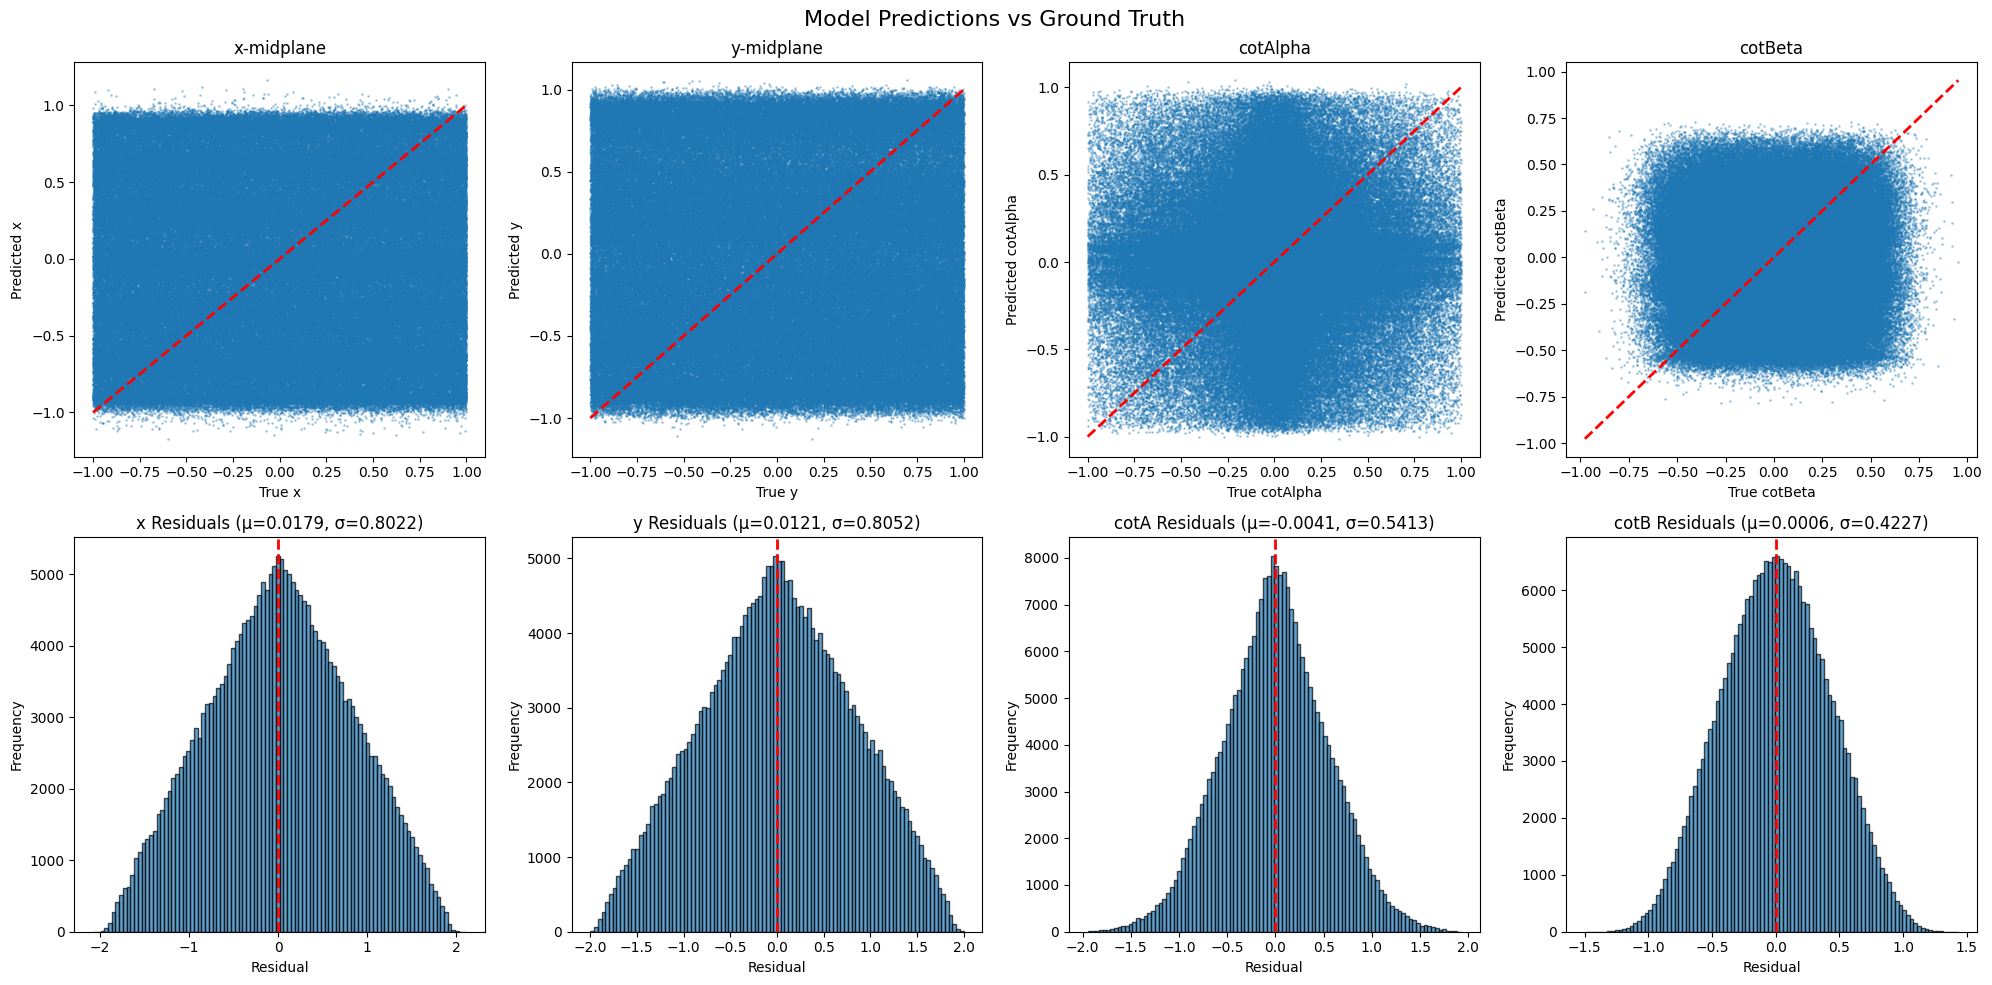


=== Summary Statistics ===

x-midplane:
  Mean residual: 0.017921
  Std residual:  0.802246
  RMSE:          0.802444

y-midplane:
  Mean residual: 0.012112
  Std residual:  0.805213
  RMSE:          0.805302

cotAlpha:
  Mean residual: -0.004093
  Std residual:  0.541264
  RMSE:          0.541279

cotBeta:
  Mean residual: 0.000632
  Std residual:  0.422707
  RMSE:          0.422707


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read the results
test_result = pd.read_csv("/home/hep/hl2822/smart-pixels-ml/evaluation_results.csv")

# Calculate residuals
test_result['residual_x'] = test_result['xtrue'] - test_result['x']
test_result['residual_y'] = test_result['ytrue'] - test_result['y']
test_result['residual_cotA'] = test_result['cotAtrue'] - test_result['cotA']
test_result['residual_cotB'] = test_result['cotBtrue'] - test_result['cotB']

# Set up the figure
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Model Predictions vs Ground Truth', fontsize=16)

# Plot 1: x prediction vs true
axes[0, 0].scatter(test_result['xtrue'], test_result['x'], alpha=0.3, s=1)
axes[0, 0].plot([test_result['xtrue'].min(), test_result['xtrue'].max()], 
                [test_result['xtrue'].min(), test_result['xtrue'].max()], 'r--', lw=2)
axes[0, 0].set_xlabel('True x')
axes[0, 0].set_ylabel('Predicted x')
axes[0, 0].set_title('x-midplane')

# Plot 2: y prediction vs true
axes[0, 1].scatter(test_result['ytrue'], test_result['y'], alpha=0.3, s=1)
axes[0, 1].plot([test_result['ytrue'].min(), test_result['ytrue'].max()], 
                [test_result['ytrue'].min(), test_result['ytrue'].max()], 'r--', lw=2)
axes[0, 1].set_xlabel('True y')
axes[0, 1].set_ylabel('Predicted y')
axes[0, 1].set_title('y-midplane')

# Plot 3: cotA prediction vs true
axes[0, 2].scatter(test_result['cotAtrue'], test_result['cotA'], alpha=0.3, s=1)
axes[0, 2].plot([test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 
                [test_result['cotAtrue'].min(), test_result['cotAtrue'].max()], 'r--', lw=2)
axes[0, 2].set_xlabel('True cotAlpha')
axes[0, 2].set_ylabel('Predicted cotAlpha')
axes[0, 2].set_title('cotAlpha')

# Plot 4: cotB prediction vs true
axes[0, 3].scatter(test_result['cotBtrue'], test_result['cotB'], alpha=0.3, s=1)
axes[0, 3].plot([test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 
                [test_result['cotBtrue'].min(), test_result['cotBtrue'].max()], 'r--', lw=2)
axes[0, 3].set_xlabel('True cotBeta')
axes[0, 3].set_ylabel('Predicted cotBeta')
axes[0, 3].set_title('cotBeta')

# Plot 5-8: Residual distributions
axes[1, 0].hist(test_result['residual_x'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'x Residuals (μ={test_result["residual_x"].mean():.4f}, σ={test_result["residual_x"].std():.4f})')
axes[1, 0].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 1].hist(test_result['residual_y'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'y Residuals (μ={test_result["residual_y"].mean():.4f}, σ={test_result["residual_y"].std():.4f})')
axes[1, 1].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 2].hist(test_result['residual_cotA'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 2].set_xlabel('Residual')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].set_title(f'cotA Residuals (μ={test_result["residual_cotA"].mean():.4f}, σ={test_result["residual_cotA"].std():.4f})')
axes[1, 2].axvline(0, color='r', linestyle='--', lw=2)

axes[1, 3].hist(test_result['residual_cotB'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 3].set_xlabel('Residual')
axes[1, 3].set_ylabel('Frequency')
axes[1, 3].set_title(f'cotB Residuals (μ={test_result["residual_cotB"].mean():.4f}, σ={test_result["residual_cotB"].std():.4f})')
axes[1, 3].axvline(0, color='r', linestyle='--', lw=2)

plt.tight_layout()
plt.savefig('test_results_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"\nx-midplane:")
print(f"  Mean residual: {test_result['residual_x'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_x'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_x']**2).mean()):.6f}")

print(f"\ny-midplane:")
print(f"  Mean residual: {test_result['residual_y'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_y'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_y']**2).mean()):.6f}")

print(f"\ncotAlpha:")
print(f"  Mean residual: {test_result['residual_cotA'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotA'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotA']**2).mean()):.6f}")

print(f"\ncotBeta:")
print(f"  Mean residual: {test_result['residual_cotB'].mean():.6f}")
print(f"  Std residual:  {test_result['residual_cotB'].std():.6f}")
print(f"  RMSE:          {np.sqrt((test_result['residual_cotB']**2).mean()):.6f}")

In [18]:
df = test_result.copy()

from tqdm import tqdm

test_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir= f"/home/hep/hl2822/smart-pixels-ml/tfrecords_{stamp}/tfrecords_test_{stamp}/",
    shuffle = True,
    seed = 13,
    quantize = True
)

complete_truth = None
for _, y in tqdm(test_generator):
    if complete_truth is None:
        complete_truth = y
    else:
        complete_truth = np.concatenate((complete_truth, y), axis=0)

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]

df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

100%|██████████| 976/976 [01:01<00:00, 15.97it/s]


In [20]:
p_test = model.predict(test_generator)

976/976 [==============================] - 62s 63ms/step


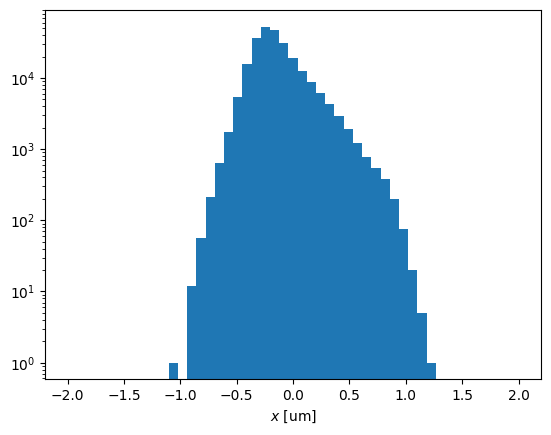

In [21]:
plt.hist(p_test[:,0],bins=np.linspace(-2,2,50))
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

plt.show()

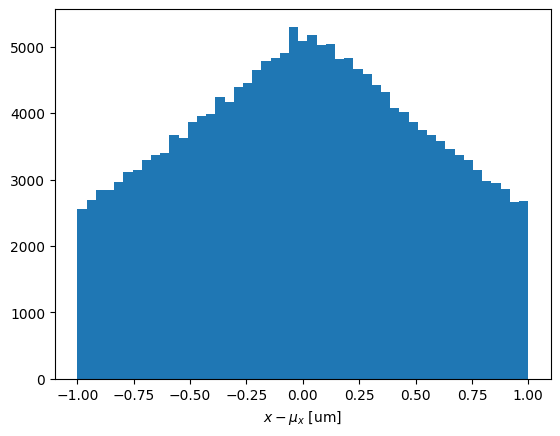

In [22]:
plt.hist(residuals,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

plt.show()

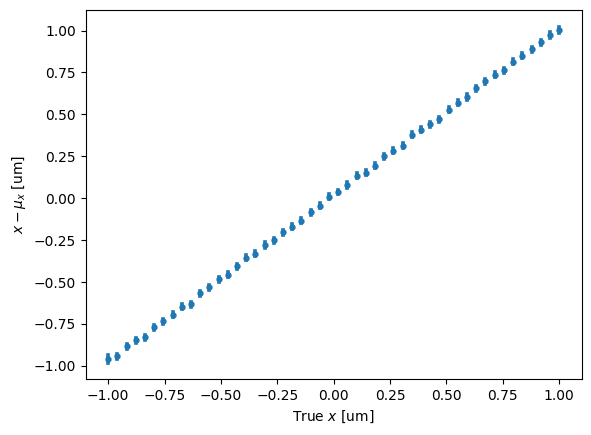

In [23]:
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

plt.show()

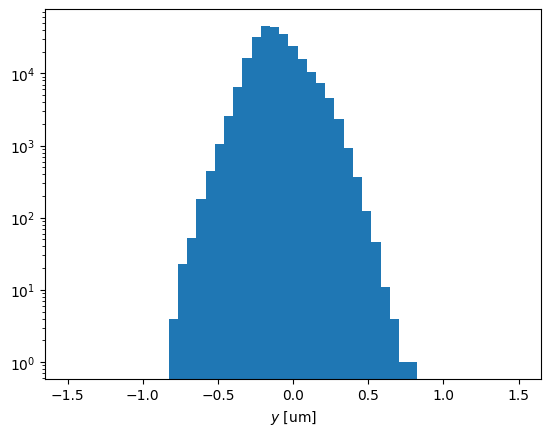

In [24]:
plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.yscale('log')
plt.xlabel(r'$y$ [um]')
plt.show()

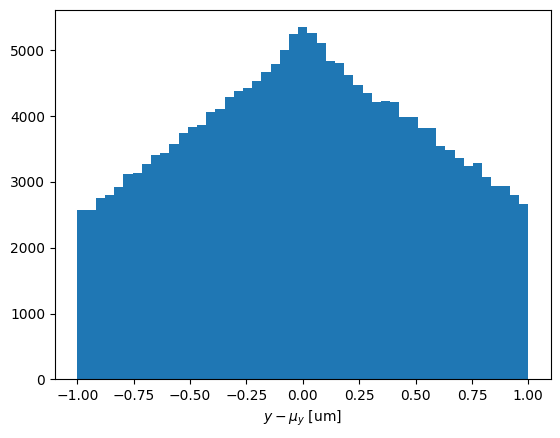

In [25]:
plt.hist(residualsy,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

plt.show()

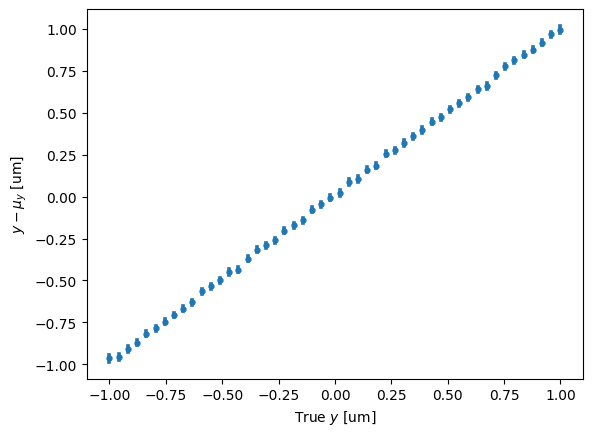

In [26]:
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

plt.show()

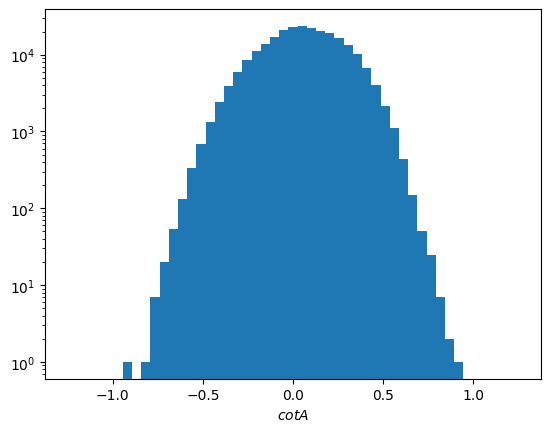

In [27]:
plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.yscale('log')
plt.xlabel(r'$cotA$')

plt.show()

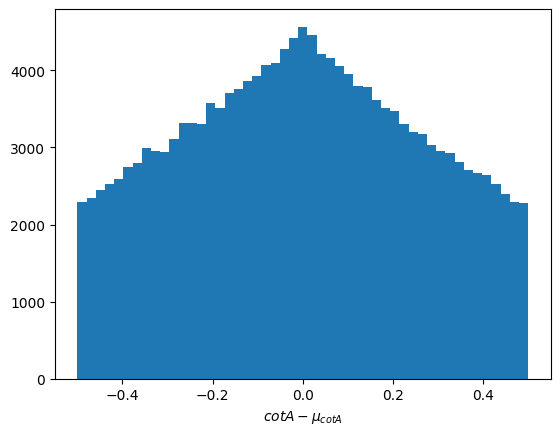

In [28]:
plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')


plt.show()

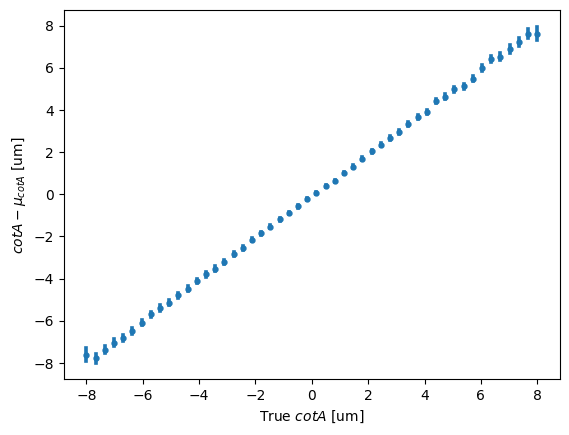

In [29]:
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

plt.show()

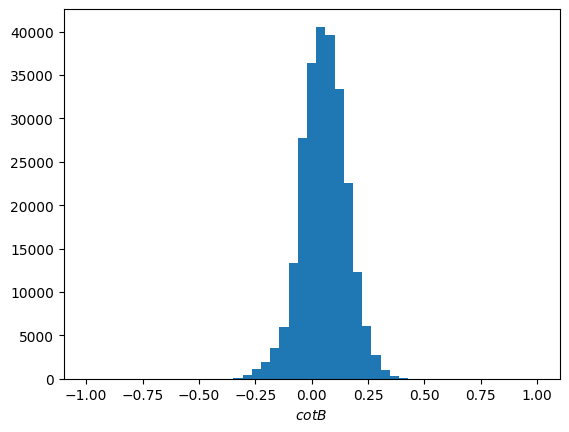

In [30]:
plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB$')


plt.show()

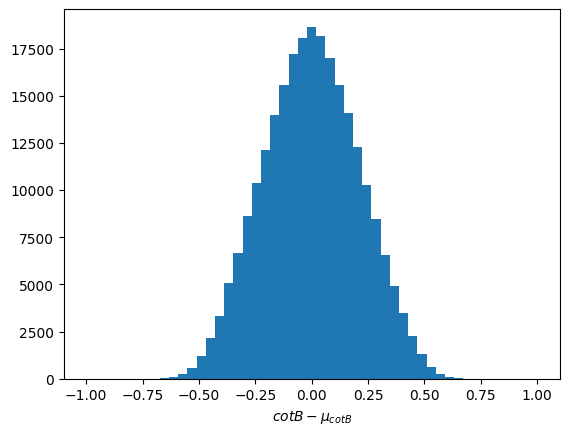

In [31]:
plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')
plt.show()

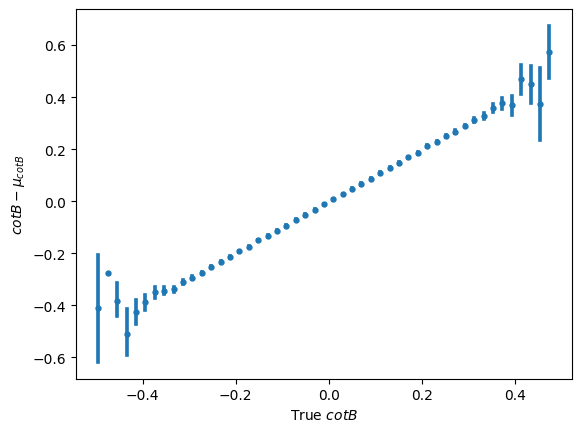

In [32]:
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')


plt.show()

In [35]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

In [36]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name, unit_gauss = True, log_scale = True):
    
    h = ax.hist(df[var],bins=np.linspace(-10,10,50),histtype='step')
    ax.set_xlabel(name)
    if log_scale: ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-10,10,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black', label='Fitted Gaussian')
    if unit_gauss: ax.plot(xbins,gauss(xbins,pars[0],0, 1),color='red', label='Unit Gaussian')
    ax.set_ylim(0.5,100000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-10,20000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-10,10000,"$\sigma$="+str(round(abs(pars[2]),2)))

    ax.legend()

Mean -0.09621047339877037
Sigma 7.405145138320595
Mean 0.24269426311085732
Sigma 8.76822161539303
Mean -0.5578467692659025
Sigma 12.728393254056993
Mean -0.13967174532133772
Sigma -4.298061738944553


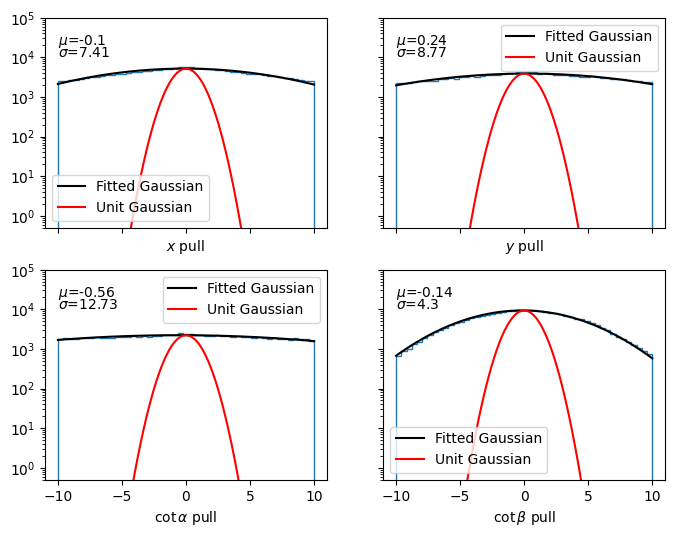

In [37]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

plt.show()

In [38]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue


/tmp/ipykernel_2357652/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


/tmp/ipykernel_2357652/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue


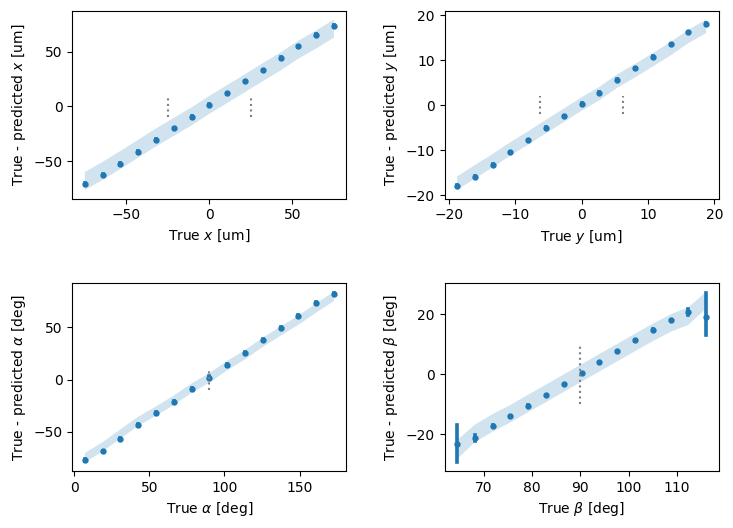

In [41]:
pi = 3.141592653589793

fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')
plt.show()

/tmp/ipykernel_2357652/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue
angletrue
angletrue


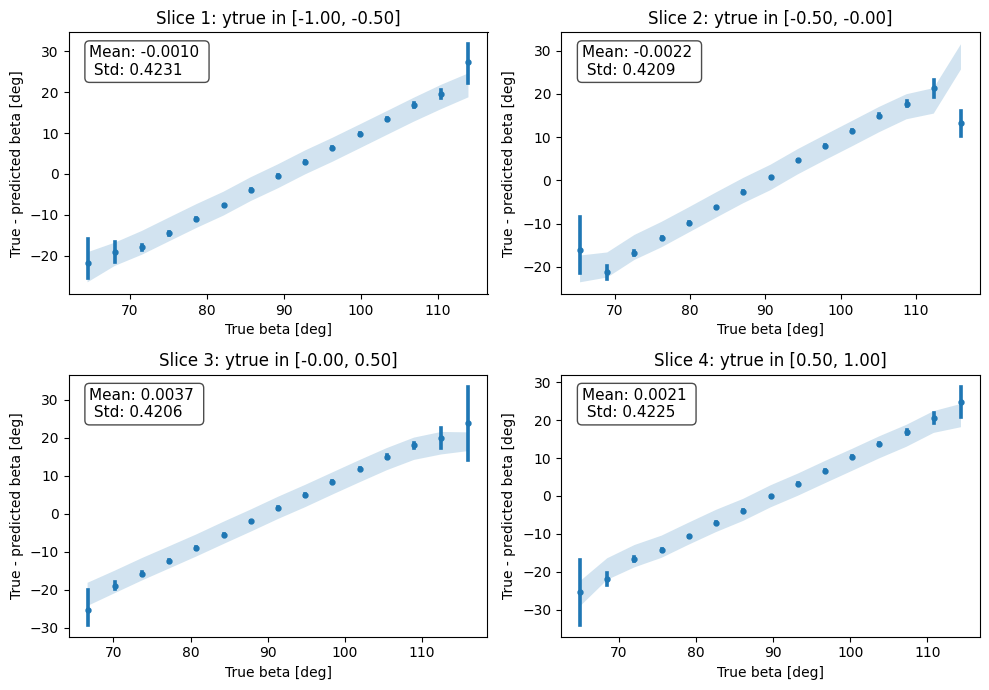

In [42]:
# Parameters
n_bins = 4
scaling = 0.5

# ytrue slices
bins = np.linspace(df['ytrue'].min(), df['ytrue'].max(), n_bins + 1)
df['y_bin'] = pd.cut(df['ytrue'], bins=bins, labels=False)

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

for i in range(n_bins):
    thisdf = df[df['y_bin'] == i].copy()
    
    # Residual calculation
    residuals = thisdf['cotBtrue'] - thisdf['cotB']
    mean_residual = residuals.mean()
    std_residual = residuals.std()
    
    ax = axs[i // 2, i % 2]
    residual_plot_deg(ax, thisdf, 'cotBtrue', 'cotB', r'beta [deg]', scaling=scaling)
    ax.set_title(f'Slice {i+1}: ytrue in [{bins[i]:.2f}, {bins[i+1]:.2f}]')

    stats_text = f'Mean: {mean_residual:.4f} \n Std: {std_residual:.4f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()